In [19]:
import cna
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
fs_axislabel = 10
fs_figsubpanel = 14
fs_legend = 8

# Talks

In [3]:
d = cna.read('_results/default-vae.h5ad'); d.sampleid = 'sid'

<Figure size 200x200 with 0 Axes>

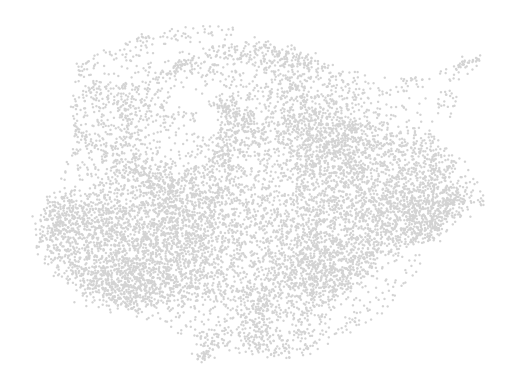

In [8]:
plt.figure(figsize=(2,2))
sc.pl.umap(d, frameon=False, show=False)
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

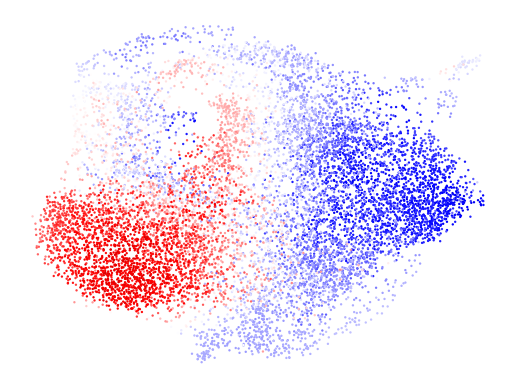

In [13]:
d.obs['PC1'] = d.uns['NAM_nbhdXpc'].PC1
sc.pl.umap(d, color='PC1', cmap='seismic', vmin=-0.03, vmax=0.03, frameon=False, colorbar_loc=None, title='', show=False)
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

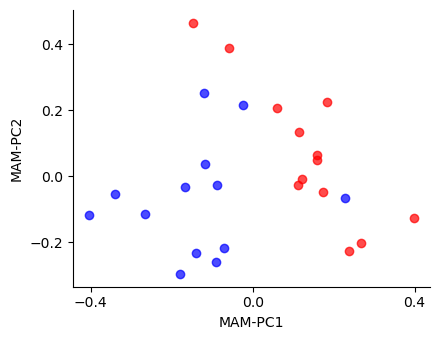

In [28]:
color_f = 'red'; color_i = 'blue'; legend = False
plt.figure(figsize=(4.5,3.5))
ax = plt.gca()
pcs = d.uns['NAM_sampleXpc']
ax.scatter(pcs[d.samplem.fstar].PC1, pcs[d.samplem.fstar].PC2, color=color_f, label='F/TF/EFM', alpha=0.7)
ax.scatter(pcs[~d.samplem.fstar].PC1, pcs[~d.samplem.fstar].PC2, color=color_i, label='M/TM/TB', alpha=0.7)
if legend:
    plt.legend(fontsize=fs_legend)
ax.set_xticks([-0.4, 0, 0.4])
ax.set_yticks([-0.2, 0, 0.2, 0.4])
ax.set_xlabel('MAM-PC1', fontsize=fs_axislabel)
ax.set_ylabel('MAM-PC2', fontsize=fs_axislabel)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

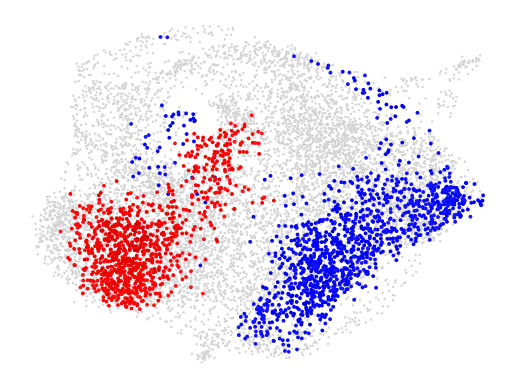

In [34]:
ax = plt.gca()
sc.pl.umap(d, ax=ax, show=False)
sc.pl.umap(d[d.obs.ncorr_thresh != 0], color='ncorr_thresh', cmap='seismic', vmin=-1, vmax=1, s=30, ax=ax, show=False,
           colorbar_loc=None, frameon=False, title='')
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

In [40]:
import tpae.vis as tv
import tpae.data.samples as tds
def fname_parser(fname):
    fname = fname.split('/')[-1].split('.nc')[0]
    return {
        'donor': fname.split('_')[0].replace('Repeat',''),
        'sid': fname
    }
repname = 'pca_k=5_harmony'
samples = tds.read_samples(f'../../RA/BHAM-data/10u/{repname}/*.nc', fname_parser)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.78it/s]


........................

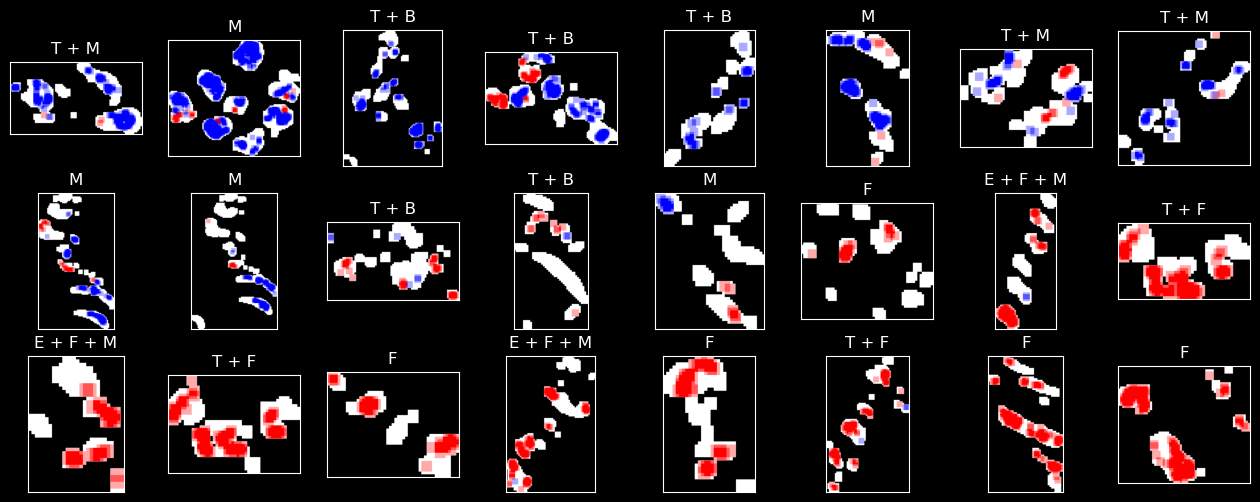

In [43]:
sortkey = d.samplem.fstar.astype(int) * 100 + d.samplem.yhat
fig = tv.spatialplot(samples,
               sortkey,
               d.obs,
               [d.obs.ncorr_thresh > 0, d.obs.ncorr_thresh < 0],
               labels=d.samplem.CTAP,
               rgbs=[[1,0,0],[0, 0, 1]],
               skipthresh=50, filterempty=True,
               vmax=3, ncols=8, size=2, show=False)
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

In [59]:
def get_or(totals, name):
    others = [c for c in totals.columns if c != name]
    oddsratios = pd.Series()
    ses = pd.Series()
    for ctap in totals.index:
        odds = totals.loc[ctap, name] / totals.loc[ctap, others].sum()
        ref = totals.loc[totals.index != ctap].sum(axis=0)
        ref_odds = ref[name] / ref[others].sum()
        ses.loc[ctap] = np.sqrt((1/totals.loc[ctap]).sum() + (1/ref).sum()) / np.log(2)
        oddsratios.loc[ctap] = odds / ref_odds
    for c in ctaporder:
        if c not in oddsratios.index:
            oddsratios.loc[c] = np.nan
            ses.loc[c] = np.nan
    return np.log2(oddsratios), ses

def enrichment(ax, posneg, name, minpatches=50):
    myclusts = [c for c in d.samplem.columns if c.startswith(posneg)]
    totals = d.samplem[['CTAP'] + myclusts].groupby('CTAP').aggregate('sum')
    totals.index = totals.index.str.replace(' + ', '')
    totals = totals.loc[totals.sum(axis=1) > minpatches]
    lors, ses = get_or(totals, name)
    lors.loc[ctaporder].plot(kind='bar', color='teal', yerr=2*ses.loc[ctaporder], ax=ax)
    ax.axhline(y=0, ls='-', color='black')
    ax.set_ylabel('$\\log_2(OR)$ for cluster 1')
    ax.set_xlabel('CTAP')
    ax.tick_params(axis='x', rotation=0)

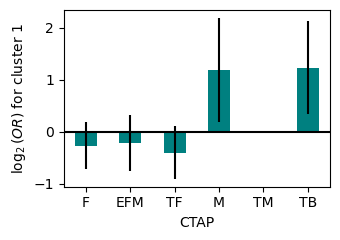

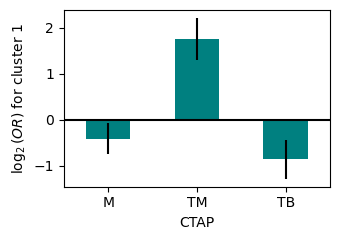

In [60]:
ctaporder = ['F','EFM','TF','M','TM','TB']
plt.figure(figsize=(3.5,2.5))
enrichment(plt.gca(), 'pos', 'pos0')
plt.tight_layout()
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

ctaporder = ['M','TM','TB']
plt.figure(figsize=(3.5,2.5))
enrichment(plt.gca(), 'neg', 'neg0')
plt.tight_layout()
plt.savefig('/Users/yakir/Desktop/temp.png')
plt.show()

# Scratch

In [ ]:
# microneighborhood examples from old rep (RA nlatent=20, training pass 1): patchids = [11, 601, 1091, 9200, 1500, 1051, 451]

In [ ]:
# plot microclusters as umap + examples
def to_polar(center, point):
    dx, dy = point[0] - center[0], point[1] - center[1]
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)  # Angle in radians
    return r, theta

from scipy.spatial.distance import mahalanobis
def remove_outliers(points, threshold=3):
    mean = np.median(points, axis=0)
    cov_matrix = np.cov(points, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    distances = np.array([mahalanobis(point, mean, inv_cov_matrix) for point in points])
    inliers = points[distances < threshold]
    return inliers

from matplotlib.patches import Ellipse
def draw_ellipse_around_points(points, ax, factor=2):    
    center = np.mean(points, axis=0)
    cov_matrix = np.cov(points - center, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues) * factor
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(ellipse)

key = 'leiden3'
# compute centroid of each cluster in polar coordinates
clustcoords = pd.DataFrame(columns=['x','y'])
for c in d.obs[key].unique():
    clustcoords.loc[c] = {
        'x' : np.median(d[d.obs[key] == c].obsm['X_umap'][:,0]),
        'y' : np.median(d[d.obs[key] == c].obsm['X_umap'][:,1])}
center = np.mean(clustcoords[['x','y']].values, axis=0)
polar_coords = [to_polar(center, point) for point in clustcoords[['x','y']].values]
clustcoords[['r','theta']] = polar_coords
clustcoords['r_discrete'] = ((clustcoords.r // 2)*2)

%%capture
# make reports for each cluster
outdir = '_results/RA/allpatchclusters'
cmap = fibro_cmap

plt.figure(figsize=(8,6))
sc.pl.umap(d, s=30, show=False, ax=plt.gca())
for s in plt.gca().spines.values():
    s.set_visible(False)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.savefig(f'{outdir}/umap.png')
plt.close()

for i, c in enumerate(clustcoords.sort_values(by=['r_discrete','theta'], ascending=False).index):
    size = d.obs[key].value_counts()[c]
    print(c, size, end='|')
    if size < 50:
        continue
    d.obs['inclust'] = d.obs[key] == c

    # plot UMAP
    plt.figure(figsize=(8,6))
    sc.pl.umap(d, s=30, show=False, ax=plt.gca())
    draw_ellipse_around_points(remove_outliers(d[d.obs.inclust].obsm['X_umap'], threshold=1), plt.gca(), factor=2.2)
    for s in plt.gca().spines.values():
        s.set_visible(False)
    plt.xlabel('UMAP 1', fontsize=14)
    plt.ylabel('UMAP 2', fontsize=14)
    plt.savefig(f'{outdir}/umap_{i}_{c}_{size}.png')
    plt.close()

    # plot example patches
    np.random.seed(0)
    idx = np.arange(len(d))[d.obs.inclust.values]
    tv.plot_patches_overlaychannels_som(
        Mdense[idx][0],
        d.X[idx],
        cmap,
        nx=8, ny=8,
        show=False,
        scale_factor=1
    )
    plt.gcf().patch.set_facecolor('black')
    plt.savefig(f'{outdir}/examples_{i}_{c}_{size}.png')
    plt.close()

    # paste together the reports
    image1 = Image.open(f'{outdir}/umap_{i}_{c}_{size}.png')
    image2 = Image.open(f'{outdir}/examples_{i}_{c}_{size}.png')
    combined_width = image1.width + image2.width
    combined_height = max(image1.height, image2.height)
    combined_image = Image.new('RGB', (combined_width, combined_height), 'white')
    combined_image.paste(image1, (0, int((combined_height-image1.height)/2)))
    combined_image.paste(image2, (image1.width, 0))
    combined_image.save(f'{outdir}/combined_{i}_{c}_{size}.png')

In [ ]:
def make_pics(clusts, clust_pics):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for c in clusts:
            idx = np.arange(len(d))[d.obs[key] == c]
            tv.plot_patches_overlaychannels_linsum(
                Mdense[idx][0],
                d.X[idx],
                cmap,
                nx=nx, ny=ny,
                seed=0,
                show=False
            )
            plt.gcf().patch.set_facecolor('black')
            clust_pics[c] = BytesIO()
            plt.savefig(clust_pics[c], format="png", bbox_inches="tight", dpi=800)
            clust_pics[c].seek(0)
            plt.close()

from PIL import Image
def plot_clust(c, x, y, label):
    cc = clustcoords.loc[c]
    line(cc.x, cc.y, umap, x+insetsize/2, y+ar*insetsize/2, fig)
    ax = fig.add_axes([x, y, insetsize, ar*insetsize], zorder=1000)
    ax.imshow(Image.open(clust_pics[c]))
    ax.axis('off')

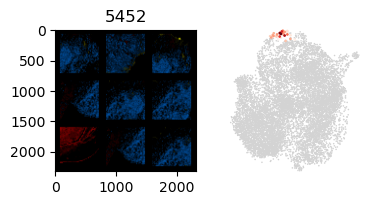

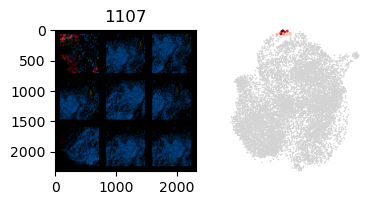

In [221]:
# choosing microneighborhoods to show
# patchids = np.argsort(((d.X - d.X[5452])**2).sum(axis=1) - 0*((d.X - d.X[8008])**2).sum(axis=1))[:50]
# patchids = [7265, 4169, 6747, 7238, 7177, 7237]
# patchids = [6857, 3972, 7527, 7237]
# patchids = [8009, 8008]
patchids = [5452, 1107]
for pid in patchids:
    mn_pics = {}
    make_pics([pid], mn_pics)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4,2))
    axs[0].imshow(Image.open(mn_pics[pid]))
    axs[0].set_title(pid)
    sc.pl.umap(d, ax=axs[1], s=5, show=False)
    sc.pl.umap(d[d.obs[f'mn_{pid}'] > 0], color=f'mn_{pid}', s=15,
               colorbar_loc=None, title='',
               cmap='Reds', ax=axs[1], frameon=False, show=False)
    plt.show()

In [ ]:
# plot patch reconstructions for different patches
for pid in np.random.choice(len(d), size=50, replace=False):
    print(pid)
    fig = plt.figure(figsize=(10, 5))
    plot_patchreconstructions(pid, 0, 0.5, 0.5, 0.5)
    plt.show()

In [ ]:
# plot marker differences between different sets of patches
from scipy.stats import ttest_ind
avgs = pd.DataFrame(Mdense[:][0].mean(axis=(1,2)), index=d.obs.index, columns=markers)
stds = pd.DataFrame(Mdense[:][0].std(axis=(1,2)), index=d.obs.index, columns=markers)

T = ttest_ind(avgs[d.obs.pos_leiden == '0'], avgs[d.obs.pos_leiden == '1'], axis=0)
np.array(markers)[T.pvalue < 0.01], T.statistic[T.pvalue < 0.01]

T = ttest_ind(avgs[d.obs.neg_leiden == '0'], avgs[d.obs.neg_leiden == '1'], axis=0)
np.array(markers)[T.pvalue < 0.01], T.statistic[T.pvalue < 0.01]

In [ ]:
tv.diff_markers(avgs, d.obs.pos_leiden == '0', d.obs.pos_leiden == '1', markers)

In [ ]:
tv.diff_markers(avgs, d.obs.neg_leiden == '0', d.obs.neg_leiden == '1', markers)
tv.diff_markers(stds, d.obs.neg_leiden == '0', d.obs.neg_leiden == '1', markers)